In [1]:
import os
import pickle
import random
import datetime
import copy
import torch
from torch.nn import Module
import tqdm
import numpy as np 
import gym
from gym import Env
from gym.spaces import Box
from gym .utils.env_checker import check_env
from typing import (
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [2]:
print(stable_baselines3.__version__)
print(gym.__version__) # should be 0.21.0 to be compatible with stable_baselines3 1.8

1.8.0
0.21.0



#### mvp
- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

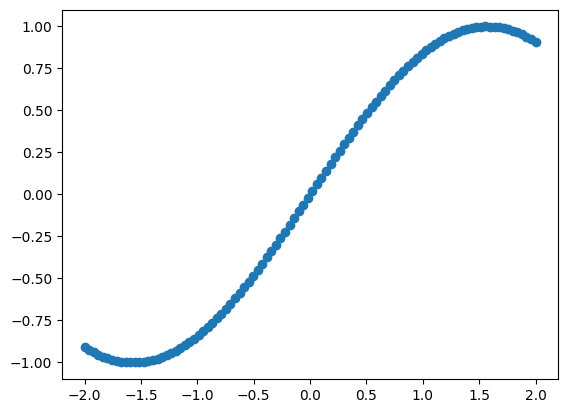

In [3]:
plt.plot(np.linspace(-2, 2, 100), np.sin(np.linspace(-2, 2, 100)), marker='o');

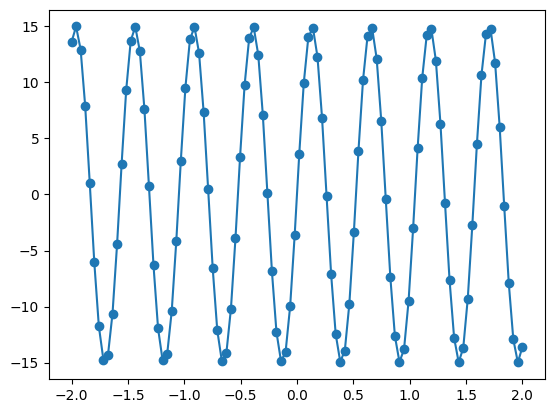

In [4]:
plt.plot(np.linspace(-2, 2, 100), 15*np.sin([12*x for x in np.linspace(-2, 2, 100)]), marker='o');
# increasing amplitude by 3 and frequency by 4

In [5]:
N = 100 # number of datapoints 
xvalues = np.linspace(-2, 2, N) 

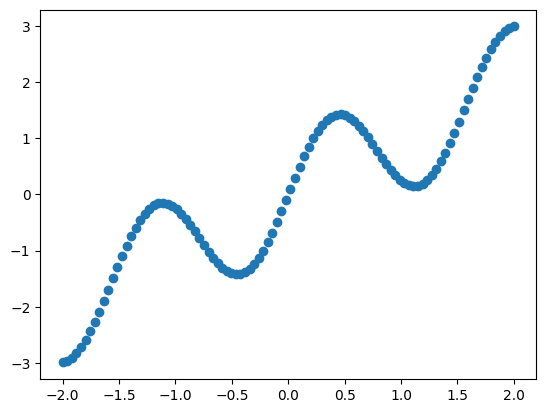

In [6]:
sine_wave = xvalues + np.sin(4*xvalues)
plt.plot(xvalues, sine_wave, 'o');

In [7]:
# y
sine_wave

array([-2.98935825, -2.95947432, -2.90353058, -2.82193204, -2.71575235,
       -2.58670583, -2.43710276, -2.26978919, -2.08807276, -1.89563649,
       -1.69644281, -1.49463023, -1.29440554, -1.09993415, -0.91523152,
       -0.74405849, -0.58982329, -0.4554927 , -0.34351473, -0.25575481,
       -0.19344717, -0.15716269, -0.14679399, -0.16155828, -0.20001769,
       -0.2601168 , -0.33923622, -0.4342608 , -0.54166086, -0.6575842 ,
       -0.77795645, -0.89858731, -1.01527972, -1.12393929, -1.22068097,
       -1.30193034, -1.36451675, -1.40575595, -1.42352009, -1.41629312,
       -1.38321035, -1.32408098, -1.23939303, -1.13030068, -0.99859414,
       -0.84665305, -0.67738437, -0.49414671, -0.30066274, -0.10092218,
        0.10092218,  0.30066274,  0.49414671,  0.67738437,  0.84665305,
        0.99859414,  1.13030068,  1.23939303,  1.32408098,  1.38321035,
        1.41629312,  1.42352009,  1.40575595,  1.36451675,  1.30193034,
        1.22068097,  1.12393929,  1.01527972,  0.89858731,  0.77

In [8]:
def build_model():
    return torch.nn.Sequential(
        torch.nn.Linear(1, 24),
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 1
        torch.nn.ReLU(),
        torch.nn.Linear(24, 24), # hidden layer 2
        torch.nn.ReLU(),
        torch.nn.Linear(24, 1)
    )

def save_model(model: torch.nn.Module,path: str) -> None:
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, path: str) -> torch.nn.Module:
    model.load_state_dict(torch.load(path))    
    
def split_data(X: np.ndarray,
               y: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # wraps sklearn's train_test_split
    # added functionality is converting to torch tensor type and reshaping
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

def train_regression_model(model: torch.nn.Module,
                           opt: torch.optim,
                           X_train: torch.Tensor, 
                           y_train: torch.Tensor, 
                           X_test: torch.Tensor, 
                           y_test: torch.Tensor, 
                           n_epochs: int=500, 
                           batch_size: int=1,
                           show_progress: bool=True) -> Tuple[List[torch.Tensor], 
                                                              List[torch.Tensor], 
                                                              float, 
                                                              OrderedDict[str, torch.tensor]]:
    loss_fn = torch.nn.MSELoss()
    best_mse = np.inf
    best_weights = None
    loss_history = []
    prediction_history = []
    
    ##############
    # 500 epochs 
    ##############
    for epoch in range(n_epochs):
        # train model on batches (which here is just a singular value)
        model.train()
        ################
        # 100 samples 
        ################
        if show_progress:
            pbar = tqdm.tqdm(total=len(X_train))
            pbar.set_description(f"Epoch {epoch}")
        for batch_index in range(round(len(X_train)/batch_size)):
            ################
            # 1 sample at a time (batch size = 1)
            ################
            X_batch = X_train[batch_index : batch_index + batch_size]
            y_batch = y_train[batch_index : batch_index + batch_size]

            # forward pass
            y_pred = model(X_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # update weights via backprop
            opt.zero_grad()
            loss.backward()
            opt.step()

            if show_progress: pbar.update(10)
        if show_progress: pbar.close()

        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        loss_history.append(mse)
        prediction_history.append(y_pred)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())
    
    return prediction_history, loss_history, best_mse, best_weights

def predict_from_composed_layers(layers, X=np.linspace(-2,2,100)):
    y_hats = []
    for x in X:
        x = torch.Tensor([x])
        for i in range(len(layers)-1):
            x = torch.nn.functional.relu(layers[i](x))
        x = layers[-1](x) # do not relu the very last calculation
        y_hats.append(x)
    return y_hats

def predict(model: torch.nn.Module, X: torch.Tensor) -> List[torch.Tensor]:
    # function to get yhat from target network
    return [model(torch.tensor(sample).float()) 
            for sample in X.reshape((N,1))]

def plot_predictions_versus_ground(X: torch.Tensor, 
                                   y: torch.Tensor, 
                                   y_hat: torch.Tensor,
                                   plot_title: str="line fit") -> None:

    # function to plot predicted curve versus actual curve
    # assumes x and y are both numpy arrays
    # assumes y_hat is generated by make_predictions()
    plt.plot(X, y)
    plt.plot(X, np.array([_.detach().numpy() for _ in y_hat]));
    plt.title(plot_title)

def calculate_pool_size(num_tasks, network_depth):
    k = 1
    return num_tasks * network_depth * k


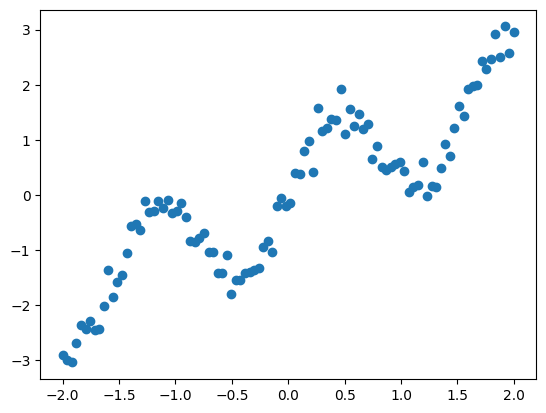

In [9]:
noisy_sine_wave = xvalues + np.sin(4*xvalues) + np.random.normal(0,0.2, 100)
plt.plot(xvalues, noisy_sine_wave, 'o');

In [10]:
x_for_split = xvalues.reshape((N,1))
X_train, y_train, X_test, y_test = split_data(x_for_split, sine_wave)
noisy_X_train, noisy_y_train, noisy_X_test, noisy_y_test = split_data(x_for_split, noisy_sine_wave)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([70, 1])
torch.Size([70, 1])
torch.Size([30, 1])
torch.Size([30, 1])


In [11]:
x_for_split.shape

(100, 1)

In [12]:
sine_wave.shape

(100,)

In [13]:
# depiction of how batch training works (i.e., that you just returned a 
# vector with as the same # of outputs and you passed inputs)
model = build_model()
print(X_train[0:5])
print(model(X_train[0:5]))
print()
print(X_train[0])
print(model(X_train[0]))

tensor([[ 0.4646],
        [-1.4747],
        [ 0.0202],
        [-1.0707],
        [-0.0606]])
tensor([[-0.1813],
        [-0.0899],
        [-0.1525],
        [-0.1005],
        [-0.1479]], grad_fn=<AddmmBackward0>)

tensor([0.4646])
tensor([-0.1813], grad_fn=<AddBackward0>)


# Global training params

In [14]:
POOL_NUM_LAYERS=100
NETWORK_DEPTH=5
NETWORK_NUM_NODES=32
SEED=123
LOSS_FN=torch.nn.MSELoss()
EPOCHS=1000
NUM_TASKS=20
MODEL=build_model()
OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)
TIMESTEPS=20000
DEVICE='cpu'

def reset_env(**kwargs):
    MODEL=build_model()
    OPT=torch.optim.Adam(MODEL.parameters(), lr=0.0001)

def print_env():
    print(f'POOL_NUM_LAYERS  {POOL_NUM_LAYERS}')
    print(f'NETWORK_DEPTH  {NETWORK_DEPTH}')
    print(f'NETWORK_NUM_NODES  {NETWORK_NUM_NODES}')
    print(f'NUM_TASKS  {NUM_TASKS}')
    print(f'SEED  {SEED}')
    print(f'LOSS_FN  {LOSS_FN}')
    print(f'EPOCHS  {EPOCHS}')
    print(f'MODEL  {MODEL}')
    print(f'OPT  {OPT}')
    print(f'TIMESTEPS  {TIMESTEPS}')
    print(f'DEVICE  {DEVICE}')

print_env()

POOL_NUM_LAYERS  100
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


# Train (normal data)

In [15]:
%%time
reset_env()
prediction_history, loss_history, best_mse, best_weights = train_regression_model(MODEL, 
                                                                                  OPT,
                                                                                  X_train, 
                                                                                  y_train, 
                                                                                  X_test, 
                                                                                  y_test, 
                                                                                  n_epochs=EPOCHS, 
                                                                                  batch_size=1, 
                                                                                  show_progress=False)

CPU times: total: 9min 58s
Wall time: 2min 29s


In [18]:
# list of length n with tensor([30,1]), where n is the number of epochs we ran
print(type(prediction_history))
print(len(prediction_history))
prediction_history[0].shape

<class 'list'>
1000


torch.Size([30, 1])

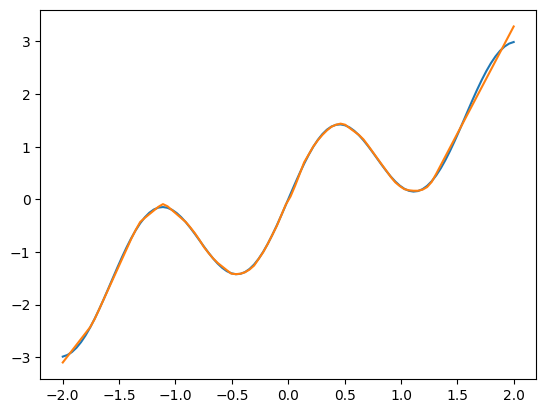

In [22]:
# print predicted values for each of the 100 x values between -2 and 2
# converting to tensor to run it through the model
# then converting it to numpy to plot it 
predictions = predict(MODEL, xvalues.reshape((N,1)))
plt.plot(xvalues, xvalues + np.sin(4*xvalues))
plt.plot(xvalues, np.array([_.detach().numpy() for _ in predictions]));

MSE: 0.00
RMSE: 0.06


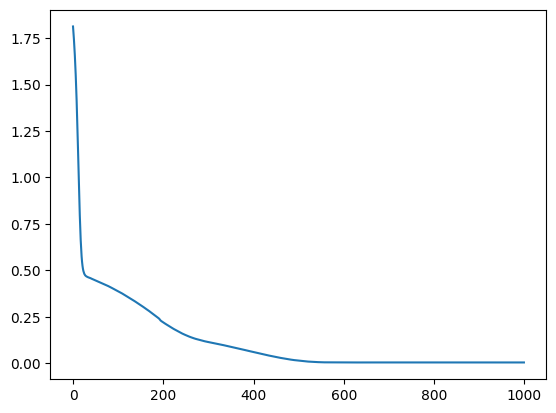

In [24]:
# visualize the mean squared error (mse)
# non-noisy sine wave
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(loss_history)
plt.show()

# Train (noisy data)

In [25]:
reset_env()

In [26]:
%%time
nprediction_history, nloss_history, nbest_mse, nbest_weights = train_regression_model(MODEL, 
                                                                                      OPT,
                                                                                      noisy_X_train, 
                                                                                      noisy_y_train, 
                                                                                      noisy_X_test, 
                                                                                      noisy_y_test, 
                                                                                      n_epochs=1000, 
                                                                                      batch_size=1, 
                                                                                      show_progress=False)

CPU times: total: 6min 45s
Wall time: 1min 2s


MSE: 0.05
RMSE: 0.22


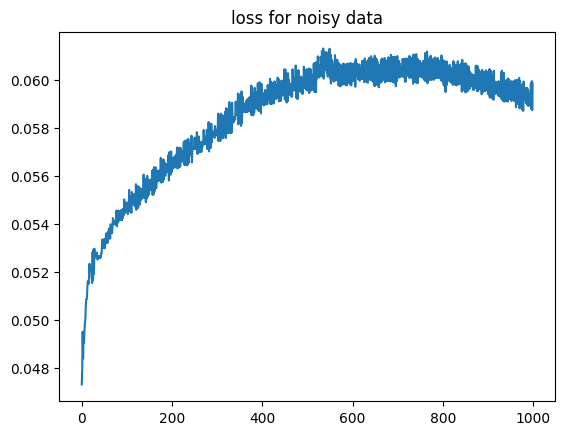

In [30]:
# noisy sine wave
print("MSE: %.2f" % nbest_mse)
print("RMSE: %.2f" % np.sqrt(nbest_mse))
plt.title("loss for noisy data")
plt.plot(nloss_history)
plt.show()

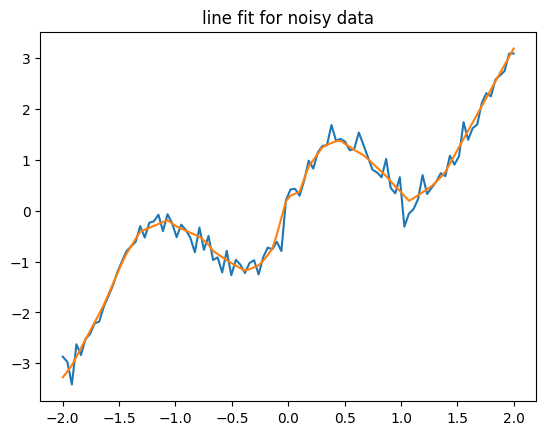

In [33]:
predictions = predict(MODEL, xvalues)
plot_predictions_versus_ground(xvalues, noisy_sine_wave, predictions, plot_title="line fit for noisy data")

# Reinforcement Meta-Learning

3 classes
- layer pool
- target network -- composed of layers from layer pool
- meta learner -- decides which layers from layer pool to add to target network

So, (meta learner) -> (layer pool) -> (target network)

In [16]:
print_env()

POOL_NUM_LAYERS  1000
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


In [60]:
class Layer:
    '''Metadata object to hold layer and track some useful information about the layer.
    '''
    def __init__(self, 
                 layer: torch.nn.Linear):
        self.layer = layer
        self.used = False
        self.times_used = 0

class LayerPool:
    '''Pool of dense layers, each with a specified number of nodes to be composed by the RL agent.
    '''
    # TODO(ms): accomodate dimensions that are not just ints
    def __init__(self, 
                 size: int, 
                 input_dim: int,
                 output_dim: int,
                 num_nodes: int=32):
        self.size = size
        self.num_nodes_per_layer = num_nodes

        # these layers comprise the layer pool
        # each layer has a metadata object associated with it that stores useful information
        # each layer that is used gets updated (i.e., their parameters change and the copy in 
        # this layer pool is updated)
        # the one exception to this update rule is the first and last layers in the network,
        # or 'initial' and 'final', below
        self.layers = { 
                       id : Layer(layer) 
                       for id, layer in enumerate([torch.nn.Linear(in_features=num_nodes, out_features=num_nodes) for _ in range(size)])
                       }
        [torch.nn.init.xavier_uniform_(layer_meta_obj.layer.weight) for layer_meta_obj in self.layers.values()]

        # these 'initial' and 'final' layers are the first layers in each target network
        # they are also uniquely updated for each target network (i.e., they aren't included in the self.layers pool
        # for other future target networks to have access to)
        # we don't have meta objects for these layers because they are used by every target network
        self.initial_layer = torch.nn.Linear(input_dim, self.num_nodes_per_layer)
        self.final_layer = torch.nn.Linear(self.num_nodes_per_layer, output_dim)
        torch.nn.init.xavier_uniform_(self.final_layer.weight)
        torch.nn.init.xavier_uniform_(self.initial_layer.weight)



In [61]:
class TargetNetwork(gym.Env, Module):
    # TODO(ms): ensure that rml can't choose the initial or final layer (i.e., these are not part of action space)
    def __init__(self, 
                 X: np.ndarray,
                 y: np.ndarray,
                 layer_pool: LayerPool,
                 depth: int=5,
                 num_nodes: int=32,
                 epsilon: float=0.1):
        super(TargetNetwork, self).__init__()
        self.observation_space = Box(low=float('-inf'), high=float('inf'), shape=(num_nodes,)) # vector with latent space of network
        self.action_space = Box(low=0., high=1., shape=(depth,)) # vector of probabilities for each layer in pool
        self.epsilon = epsilon

        # data 
        self.X = X
        self.y = y
        self.curr_i = 0
        self.curr_x = torch.Tensor( [X[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.curr_y = torch.Tensor( [y[0]] ) # these parameterize the parameterized state (i.e., layer has parameters, and x passed through has value/parameter)
        self.layer_pool = layer_pool

        # nn module
        # https://discuss.pytorch.org/t/how-to-add-a-layer-to-an-existing-neural-network/30129/3
        self.depth = depth
        self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer]) # every target network begins with the same initial and final layers
        self.state = self.reset() 
        self.layerpool_indices = [] # doesn't include the indices of 'initial' and 'final' layers because they don't exist
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001)

    def run_inner_loop(self) -> Tuple[np.ndarray, float]: 
        '''
        Performs inference using "inner loop" network that we are composing. Returns next state and its reward.

        NOTE Design choice whether to train with new layer first. Currently training first.
        '''
        self.train()
        self.curr_i  = (self.curr_i + 1) % len(self.X) # go through data multiple times / dataset does not dictate truncation condition
        self.curr_x = torch.Tensor( [self.X[self.curr_i]] ) 
        self.curr_y = torch.Tensor( [self.y[self.curr_i]] )

        def predict(x):
            for i in range(len(self.fcs) - 1): # -1 because we don't want the last output layer yet
                x = torch.nn.functional.relu(self.fcs[i](x))
            s_prime = x
            y_hat = self.fcs[-1](x)
        
            return self.loss_fn(self.curr_y, y_hat), s_prime, self.loss_fn(self.curr_y, y_hat)

        # update params
        loss, s_prime, reward = predict(self.curr_x)
        self.opt = torch.optim.Adam(self.fcs.parameters(), lr=0.001) # re-create because parameters added
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # push updated params to pool (NOTE  handled by the rml class going forward.)
        # for i in range(len(self.layerpool_indices)):
        #     pool_index = self.layerpool_indices[i]
        #     updated_layer_copy = self.fcs[i+1]
        #     self.layer_pool.layers[pool_index].layer = updated_layer_copy
        #     self.layer_pool.layers[pool_index].used = True
        #     self.layer_pool.layers[pool_index].times_used += 1
        
        # return updated state and reward
        # NOTE  This is the second time we call predict. The first time was used to train the model.
        _, s_prime, reward = predict(self.curr_x)

        return s_prime.detach().numpy().T.squeeze(), float(reward.detach().numpy())

    def reset(self) -> np.ndarray:
        # BUG  Stablebaselines3 seems to call the reset() method even when we're not terminating.
        # self.fcs = torch.nn.ModuleList([self.layer_pool.initial_layer, self.layer_pool.final_layer])

        initial_x = torch.Tensor( [self.X[0]] )
        initial_state = torch.nn.functional.relu(self.fcs[0](initial_x))

        return initial_state.detach().numpy().T.squeeze() # TODO(ms): is there a better way to massage this data?
    
    def epsilon_greedy(self, probabilities):
        if random.random() <= self.epsilon:
            pool_index = random.randint(0, len(probabilities)-1)
        else:
            pool_index = np.argmax(probabilities)

        self.layerpool_indices.append(pool_index)
        next_layer = self.layer_pool.layers[pool_index].layer

        return next_layer
    
    def step(self, action: np.ndarray) -> Tuple[torch.Tensor, int, bool, dict]: # "given some new layer"
        if len(self.fcs) < self.depth:
            next_layer = self.epsilon_greedy(action) # action is probability for each layer in pool
            final_layer = self.fcs.pop(-1)
            self.fcs.append(next_layer)  # compose new layer 
            self.fcs.append(final_layer) # re-insert final layer
        s_prime, reward = self.run_inner_loop()

        # temporary terminate logic
        done = False # TODO(ms): update to make episodic? is this continuous learning?

        return (
            s_prime,
            reward, 
            done, 
            {}
        )
    
    def render(self, mode='human', close=False):
        print(f'[INFO] # of layers {len(self.fcs)}')

    def close(self):
        pass

In [71]:
class Rlmetalearn:
    '''
    Meta-policy. The parameters are learned by training on multiple different tasks, where
    each task is represented by a different dataset (X,y) and is an instance of the 
    TargetNetwork class.

    Uses multiple environmental variables, whose default values are specified with print_env().

    Example usage.
        $ pool = LayerPool(in_features, out_features)  # this assumes the same architecture for every layer in the pool
        $ tasks = { str(round(f))+str("_task") : ((np.linspace(-2, 2, 100), (xvalues/round(f)) + np.sin(4*xvalues) + np.random.normal(0, 0.2, 100) for f in np.linspace(1, 1000, NUM_TASKS)) }
        $ rml = ReinforcementMetaLearning(pool, tasks)  # "you have this pool of layers, now learn these tasks"
        $ rml.train()
        $ rml.introspect(X, y) # TODO(ms): decide what this will do, then how.

    https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#example

    '''
    def __init__(self,
                layer_pool,
                tasks,
                timesteps=5000,
                device='cpu',
                overwrite=True, 
                intra_update=True,
                network_depth_limit=5,
                network_num_nodes=32,
                epsilon=0.1):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.out_features = np.array(self.tasks[list(self.tasks.keys())[0]][1]).shape # output shape; assumes uniformity across tasks
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite  # TODO(ms): to implement this, need some filter on the actions returned
        self.intra_update = intra_update
        self.network_depth_limit = network_depth_limit
        self.network_num_nodes = network_num_nodes
        self.epsilon = epsilon
        self.epoch_to_yhats_by_task = {}
        self.epoch_to_layerindices_by_task = {}

    def train(self):
        '''
        The meta learner has one policy that it continues to update across
        tasks.

        We update the env for the meta policy for each new task.

        This then trains for n timesteps, where the timestemps are greater than the number
        of data points, so it goes through the dataset over and over with a modulo???
        '''
        # train on all tasks
        epoch_to_yhats_by_task = {}
        epoch_to_layerindices_by_task = {}
        for epoch in range(EPOCHS): # 1000 epochs
            print(f'[INFO] Epoch {epoch +1}/{EPOCHS}...')
            task_to_yhats = {}
            task_to_layerindices = {}
            for i, (task_id, (X, y)) in enumerate(self.tasks.items()):
                print(f'[INFO] ...task {i+1}/{len(self.tasks)}')
                env = TargetNetwork(X, 
                                    y, 
                                    self.layer_pool,
                                    self.network_depth_limit,
                                    self.network_num_nodes,
                                    self.epsilon)

                if epoch==0: model  = A2C('MlpPolicy', env) # done once
                else: # continue to update the same meta policy with different tasks (envs)
                    model.set_env(env)

                # use stablebaselines3 api to learn
                model.learn(total_timesteps=self.timesteps) # 20000 timesteps 

                # predict and store
                y_hats = predict_from_composed_layers(env.fcs)
                task_to_yhats[task_id] = y_hats
                task_to_layerindices[task_id] = env.layerpool_indices
                print(f'epoch to yhats {task_to_yhats}')
                print(f'epoch to layers {task_to_layerindices}')

                # update
                self.update_params(env.layerpool_indices, env.fcs)
            
            epoch_to_yhats_by_task[epoch] = task_to_yhats
            epoch_to_layerindices_by_task[epoch] = task_to_layerindices
        self.epoch_to_yhats_by_task = epoch_to_yhats_by_task          # { (epoch in 50 epochs) : { (task in 20 tasks) : (100 predictions, where 100 is the number of x values) } } 
        self.epoch_to_layers_by_task = epoch_to_layerindices_by_task  # { (epoch in 50 epochs) : { (task in 20 tasks) : (indices to layer pool, which will have the meta Layer object) } }
        

    def update_params(self, pool_indices, layers):
        # push updated params to pool
        # NOTE  number of layerpool_indices and layers should be 1:1
        for i in range(len(pool_indices)):
            pool_index = pool_indices[i]
            updated_layer_copy = layers[i+1]
            self.layer_pool.layers[pool_index].layer = updated_layer_copy
            self.layer_pool.layers[pool_index].used = True
            self.layer_pool.layers[pool_index].times_used += 1
    
    def save(self):
        time = datetime.datetime.now().strftime("%H:%M:%S").replace(':', '')
        yhats_pkl_name = "{0}_yhats.pkl".format(time)
        indices_pkl_name = "{0}_indices.pkl".format(time)
        pool_pkl_name = "{0}_pool.pkl".format(time)

        with open(yhats_pkl_name, 'wb') as yhats_pkl:
            pickle.dump(self.epoch_to_yhats_by_task, yhats_pkl)

        with open(indices_pkl_name, 'wb') as indices_pkl:
            pickle.dump(self.epoch_to_layers_by_task, indices_pkl)

        with open(pool_pkl_name, 'wb') as pool_pkl:
            pickle.dump(self.layer_pool, pool_pkl)
    
    def load(self):
        paths = os.listdir(os.getcwd())
        yhats_pkl_name = [path for path in paths if 'yhats' in path][0]
        indices_pkl_name =  [path for path in paths if 'indices' in path][0]
        pool_pkl_name =  [path for path in paths if 'pool' in path][0]
        yhats_loaded, indices_loaded, pool_loaded = {}, {}, {}

        with open(yhats_pkl_name, 'rb') as yhats_pkl:
            yhats_loaded = pickle.load(yhats_pkl)

        with open(indices_pkl_name, 'rb') as indices_pkl:
            indices_loaded = pickle.load(indices_pkl)

        with open(pool_pkl_name, 'rb') as pool_pkl:
            pool_loaded = pickle.load(pool_pkl)
        
        return yhats_loaded, indices_loaded, pool_loaded

## Initial test

In [72]:
print_env()

POOL_NUM_LAYERS  100
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  5000
DEVICE  cpu


In [64]:
TIMESTEPS=5000

In [70]:
%%time
X = xvalues     # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

layer_pool = LayerPool(size=POOL_NUM_LAYERS, input_dim=in_features, output_dim=out_features, num_nodes=NETWORK_NUM_NODES)
env = TargetNetwork(X, y, layer_pool)

metarl = A2C('MlpPolicy', env)
metarl.learn(total_timesteps=TIMESTEPS)          

CPU times: total: 1min 11s
Wall time: 14.9 s


In [71]:
# performance
y_hats = []
for x in np.linspace(-2,2,100):
    x = torch.Tensor([x])
    for i in range(len(env.fcs)-1):
        x = torch.nn.functional.relu(env.fcs[i](x))
    x = env.fcs[-1](x) # do not relu the very last calculation
    y_hats.append(x)
print(y_hats)

[tensor([-2.3032], grad_fn=<AddBackward0>), tensor([-2.2724], grad_fn=<AddBackward0>), tensor([-2.2407], grad_fn=<AddBackward0>), tensor([-2.2090], grad_fn=<AddBackward0>), tensor([-2.1772], grad_fn=<AddBackward0>), tensor([-2.1438], grad_fn=<AddBackward0>), tensor([-2.1062], grad_fn=<AddBackward0>), tensor([-2.0689], grad_fn=<AddBackward0>), tensor([-2.0323], grad_fn=<AddBackward0>), tensor([-1.9967], grad_fn=<AddBackward0>), tensor([-1.9643], grad_fn=<AddBackward0>), tensor([-1.9330], grad_fn=<AddBackward0>), tensor([-1.9025], grad_fn=<AddBackward0>), tensor([-1.8721], grad_fn=<AddBackward0>), tensor([-1.8426], grad_fn=<AddBackward0>), tensor([-1.8134], grad_fn=<AddBackward0>), tensor([-1.7847], grad_fn=<AddBackward0>), tensor([-1.7580], grad_fn=<AddBackward0>), tensor([-1.7314], grad_fn=<AddBackward0>), tensor([-1.7048], grad_fn=<AddBackward0>), tensor([-1.6782], grad_fn=<AddBackward0>), tensor([-1.6515], grad_fn=<AddBackward0>), tensor([-1.6249], grad_fn=<AddBackward0>), tensor([-1

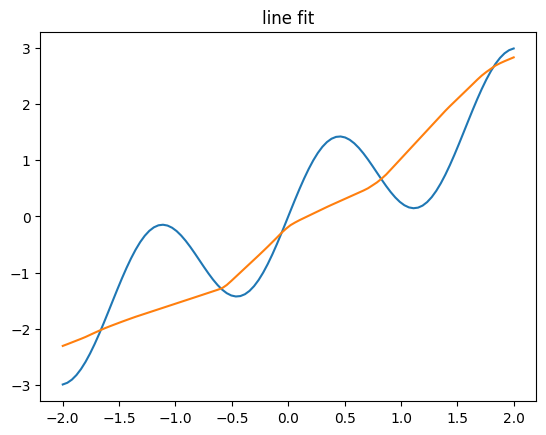

In [72]:
plot_predictions_versus_ground(np.linspace(-2,2,100), sine_wave, y_hats)

## Experiment: increasing # of layers

More layers don't help (this simple example). They do hurt performance somewhat, but after a certain depth, it becomes random and a network with thousands more layers can perform better than a network with thousands more layers less.

### 5 -> 50 depth networks (5 step size)

In [57]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(5, 50, 5):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 5:  [tensor([-2.6857], grad_fn=<AddBackward0>), tensor([-2.6110], grad_fn=<AddBackward0>), tensor([-2.5245], grad_fn=<AddBackward0>), tensor([-2.4118], grad_fn=<AddBackward0>), tensor([-2.2911], grad_fn=<AddBackward0>), tensor([-2.1597], grad_fn=<AddBackward0>), tensor([-2.0256], grad_fn=<AddBackward0>), tensor([-1.8915], grad_fn=<AddBackward0>), tensor([-1.7573], grad_fn=<AddBackward0>), tensor([-1.6232], grad_fn=<AddBackward0>), tensor([-1.4891], grad_fn=<AddBackward0>), tensor([-1.3549], grad_fn=<AddBackward0>), tensor([-1.2325], grad_fn=<AddBackward0>), tensor([-1.1305], grad_fn=<AddBackward0>), tensor([-1.0286], grad_fn=<AddBackward0>), tensor([-0.9266], grad_fn=<AddBackward0>), tensor([-0.8247], grad_fn=<AddBackward0>), tensor([-0.7227], grad_fn=<AddBackward0>), tensor([-0.6208], grad_fn=<AddBackward0>), tensor([-0.5225], grad_fn=<AddBackward0>), tensor([-0.4332], grad_fn=<AddBackward0>), tensor([-0.3488], grad_fn=<AddBackward0>), tensor([-0.2825], grad_fn=<AddBackward0>), 

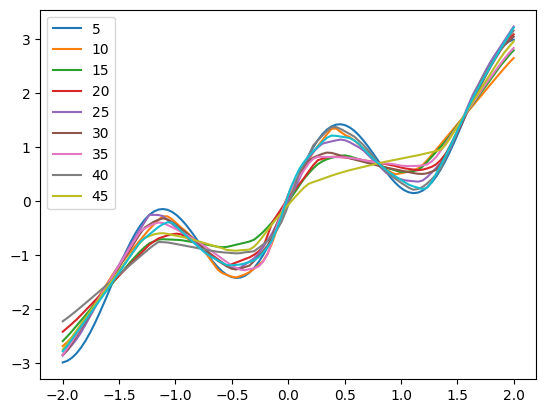

In [63]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

In [64]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 100, 10):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.9578], grad_fn=<AddBackward0>), tensor([-2.8413], grad_fn=<AddBackward0>), tensor([-2.7201], grad_fn=<AddBackward0>), tensor([-2.5898], grad_fn=<AddBackward0>), tensor([-2.4468], grad_fn=<AddBackward0>), tensor([-2.2985], grad_fn=<AddBackward0>), tensor([-2.1501], grad_fn=<AddBackward0>), tensor([-2.0018], grad_fn=<AddBackward0>), tensor([-1.8535], grad_fn=<AddBackward0>), tensor([-1.7052], grad_fn=<AddBackward0>), tensor([-1.5538], grad_fn=<AddBackward0>), tensor([-1.3997], grad_fn=<AddBackward0>), tensor([-1.2456], grad_fn=<AddBackward0>), tensor([-1.1174], grad_fn=<AddBackward0>), tensor([-1.0031], grad_fn=<AddBackward0>), tensor([-0.8888], grad_fn=<AddBackward0>), tensor([-0.7745], grad_fn=<AddBackward0>), tensor([-0.6663], grad_fn=<AddBackward0>), tensor([-0.5694], grad_fn=<AddBackward0>), tensor([-0.4955], grad_fn=<AddBackward0>), tensor([-0.4298], grad_fn=<AddBackward0>), tensor([-0.4184], grad_fn=<AddBackward0>), tensor([-0.4353], grad_fn=<AddBackward0>),

### 10 -> 100 depth networks (10 step size)

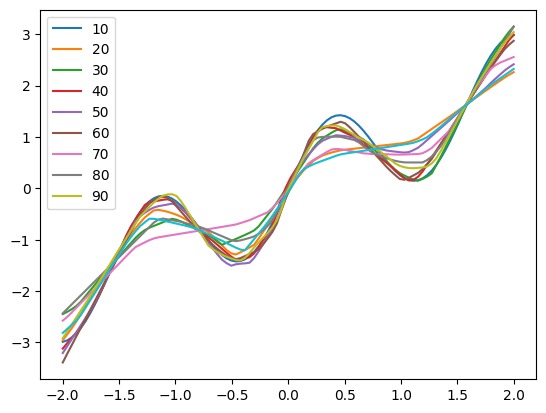

In [66]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### 10 -> 1010 depth networks (1000 step size)

In [67]:
%%time
X = xvalues # (100,1) <- np.linscape(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

depth_to_yhats = {}
for num_layers in np.arange(10, 10010, 1000):
    reset_env(NUM_LAYERS=num_layers)
    layer_pool = LayerPool(in_features, out_features, num_layers=NUM_POOL_LAYERS)
    env = TargetNetwork(
        X, 
        y, 
        layer_pool, 
        max_target_layers=MAX_TARGET_LAYERS,
        num_nodes_per_layer=NUM_NODES,
        )
    metarl = A2C('MlpPolicy', env)
    metarl.learn(total_timesteps=TIMESTEPS)          
    y_hats = predict_from_composed_layers(env.fcs)
    print(f'depth {num_layers}:  {y_hats}')
    depth_to_yhats[num_layers] = y_hats

depth 10:  [tensor([-2.6770], grad_fn=<AddBackward0>), tensor([-2.5701], grad_fn=<AddBackward0>), tensor([-2.4563], grad_fn=<AddBackward0>), tensor([-2.3424], grad_fn=<AddBackward0>), tensor([-2.2285], grad_fn=<AddBackward0>), tensor([-2.1142], grad_fn=<AddBackward0>), tensor([-1.9919], grad_fn=<AddBackward0>), tensor([-1.8697], grad_fn=<AddBackward0>), tensor([-1.7474], grad_fn=<AddBackward0>), tensor([-1.6242], grad_fn=<AddBackward0>), tensor([-1.5009], grad_fn=<AddBackward0>), tensor([-1.3776], grad_fn=<AddBackward0>), tensor([-1.2544], grad_fn=<AddBackward0>), tensor([-1.1311], grad_fn=<AddBackward0>), tensor([-1.0078], grad_fn=<AddBackward0>), tensor([-0.8845], grad_fn=<AddBackward0>), tensor([-0.7615], grad_fn=<AddBackward0>), tensor([-0.6402], grad_fn=<AddBackward0>), tensor([-0.5265], grad_fn=<AddBackward0>), tensor([-0.4165], grad_fn=<AddBackward0>), tensor([-0.3581], grad_fn=<AddBackward0>), tensor([-0.3035], grad_fn=<AddBackward0>), tensor([-0.2515], grad_fn=<AddBackward0>),

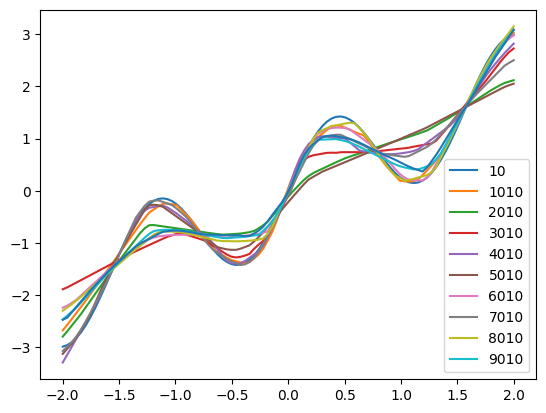

In [68]:
plt.plot(X, y)
for y_hats in depth_to_yhats.values():
    plt.plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
plt.legend([str(depth) for depth in depth_to_yhats.keys()]);

### Experiment: layer reuse on multiple tasks

In [ ]:
print_env()

POOL_NUM_LAYERS  1000
NETWORK_DEPTH  5
NETWORK_NUM_NODES  32
NUM_TASKS  20
SEED  123
LOSS_FN  MSELoss()
EPOCHS  1000
MODEL  Sequential(
  (0): Linear(in_features=1, out_features=24, bias=True)
  (1): ReLU()
  (2): Linear(in_features=24, out_features=24, bias=True)
  (3): ReLU()
  (4): Linear(in_features=24, out_features=24, bias=True)
  (5): ReLU()
  (6): Linear(in_features=24, out_features=1, bias=True)
)
OPT  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
TIMESTEPS  20000
DEVICE  cpu


### Baby example with just 1 epoch
However, 1 epoch is still going through all 20 tasks, generating 20 different networks, using the same 1 meta policy. Also, on each task we loop through the data 1000 times (timesteps / len(X) == 10000 / 100).
<br>
The benefit of more epochs is we get the meta policy to gnerate 20 different networks again for the 20 tasks, having hopefully learned something from the first run.

In [73]:
TIMESTEPS=5000
NUM_TASKS=20
NETWORK_DEPTH=5
POOL_NUM_LAYERS=calculate_pool_size(NUM_TASKS, NETWORK_DEPTH)
EPOCHS=1

In [74]:
X = xvalues # (100,1) <- np.linspace(-2, 2, 100)
y = sine_wave   # (100,) <- [np.sin(x) for x in X]
in_features = 1
out_features = 1

In [75]:
# create tasks
tasks = {
    str(round(f))+str("_task") : (xvalues, 
                                  (A*np.sin(f*xvalues) + np.random.normal(0, 0.2, 100))) 
                                  for A, f in zip(np.linspace(1, NUM_TASKS, NUM_TASKS), np.linspace(1, NUM_TASKS, NUM_TASKS))
    }

In [76]:
# create pool
pool = LayerPool(size=POOL_NUM_LAYERS, input_dim=in_features, output_dim=out_features, num_nodes=NETWORK_NUM_NODES)

In [77]:
%%time
# train outer-loop on 20 tasks
rml = Rlmetalearn(pool, tasks, epsilon=0.1)

CPU times: total: 0 ns
Wall time: 0 ns


In [78]:
%%time
rml.train()

[INFO] Epoch 1/1...
[INFO] ...task 1/20
epoch to yhats {'1_task': [tensor([-1.1521], grad_fn=<AddBackward0>), tensor([-1.1352], grad_fn=<AddBackward0>), tensor([-1.1180], grad_fn=<AddBackward0>), tensor([-1.1008], grad_fn=<AddBackward0>), tensor([-1.0837], grad_fn=<AddBackward0>), tensor([-1.0665], grad_fn=<AddBackward0>), tensor([-1.0494], grad_fn=<AddBackward0>), tensor([-1.0322], grad_fn=<AddBackward0>), tensor([-1.0150], grad_fn=<AddBackward0>), tensor([-0.9979], grad_fn=<AddBackward0>), tensor([-0.9807], grad_fn=<AddBackward0>), tensor([-0.9635], grad_fn=<AddBackward0>), tensor([-0.9464], grad_fn=<AddBackward0>), tensor([-0.9292], grad_fn=<AddBackward0>), tensor([-0.9120], grad_fn=<AddBackward0>), tensor([-0.8949], grad_fn=<AddBackward0>), tensor([-0.8777], grad_fn=<AddBackward0>), tensor([-0.8606], grad_fn=<AddBackward0>), tensor([-0.8434], grad_fn=<AddBackward0>), tensor([-0.8262], grad_fn=<AddBackward0>), tensor([-0.8089], grad_fn=<AddBackward0>), tensor([-0.7910], grad_fn=<Add

In [79]:
rml.save()

In [25]:
with open('192519_yhats.pkl', 'rb') as fp:
    yhatsd = pickle.load(fp)
print(yhatsd.keys())

dict_keys([0])


In [80]:
yhats, indices, pool = rml.load()

In [81]:
yhats # { task : yhats } where we have 20 tasks, and 100 yhats for 1 tasks

{0: {'1_task': [tensor([-1.1521], requires_grad=True),
   tensor([-1.1352], requires_grad=True),
   tensor([-1.1180], requires_grad=True),
   tensor([-1.1008], requires_grad=True),
   tensor([-1.0837], requires_grad=True),
   tensor([-1.0665], requires_grad=True),
   tensor([-1.0494], requires_grad=True),
   tensor([-1.0322], requires_grad=True),
   tensor([-1.0150], requires_grad=True),
   tensor([-0.9979], requires_grad=True),
   tensor([-0.9807], requires_grad=True),
   tensor([-0.9635], requires_grad=True),
   tensor([-0.9464], requires_grad=True),
   tensor([-0.9292], requires_grad=True),
   tensor([-0.9120], requires_grad=True),
   tensor([-0.8949], requires_grad=True),
   tensor([-0.8777], requires_grad=True),
   tensor([-0.8606], requires_grad=True),
   tensor([-0.8434], requires_grad=True),
   tensor([-0.8262], requires_grad=True),
   tensor([-0.8089], requires_grad=True),
   tensor([-0.7910], requires_grad=True),
   tensor([-0.7728], requires_grad=True),
   tensor([-0.7544], 

In [82]:
indices # error. it shouldn't be empty

{}

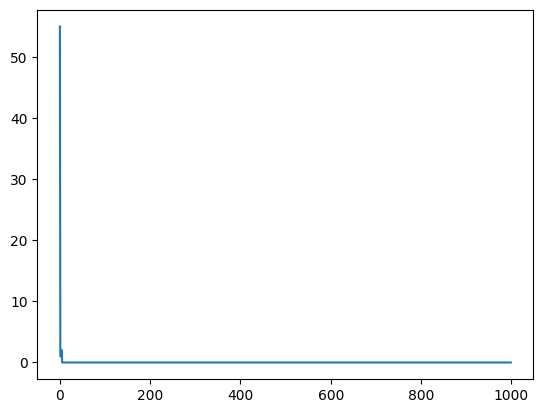

In [29]:
times_each_layer_used = [layer.times_used for layer in pool.layers.values()]
plt.plot(range(1000), times_each_layer_used)
# not a good graph, this shows that only the first few layers get used and most don't get touched
# but I thought I had less than 1000 layers for that reason

In [43]:
len(yhats[0])

20

### Loss w/ transfer vs. w/o transfer

In [ ]:
# y - loss
# x - timesteps

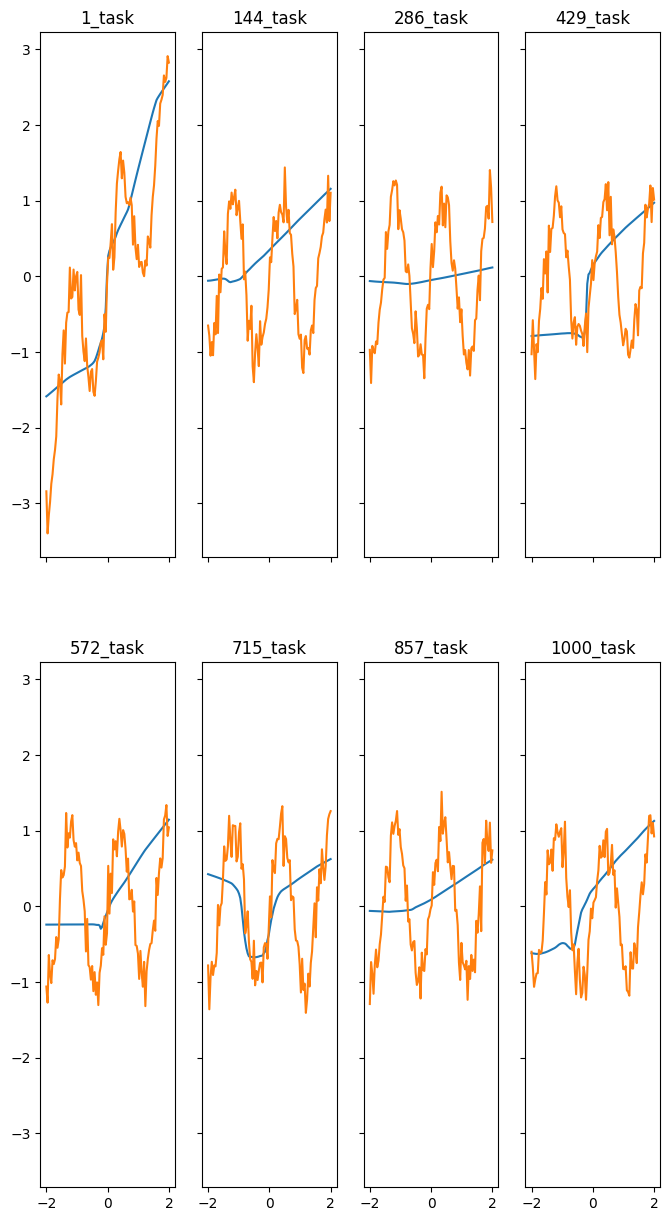

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1